In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint

In [12]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

df_10 = df.iloc[1049:1169]

df_10 = df_10.rename(columns={'Unnamed: 0': 'Date'})

df_10['Date'] = pd.to_datetime(df_10['Date'], format='%Y%m')

df_10.set_index('Date', inplace=True)

df_10 =df_10.apply(pd.to_numeric, errors='coerce')

ret_5 = df_5.values / 100
var_5 = np.var(ret_5, axis=0, keepdims=True)
std_5 = np.sqrt(np.var(ret_5, axis=0, keepdims=True))

ret_10 = df_10.values / 100
var_10 = np.var(ret_10, axis=0, keepdims=True)
std_10 = np.sqrt(np.var(ret_10, axis=0, keepdims=True))


# Plage des rendements cibles
target_returns = np.linspace(-0.10, 0.10, num=100)  # Génère 100 valeurs entre -10% et 10%

rf = 0.44 / 100

z_bar_5 = np.transpose(np.mean(ret_5, axis=0, keepdims=True))
sigma_5 = np.cov(ret_5, rowvar=False)

z_bar_10 = np.transpose(np.mean(ret_10, axis=0, keepdims=True))
sigma_10 = np.cov(ret_10, rowvar=False)

z_barre = np.mean(ret_5, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
Sigma_5 = np.cov(ret_5.T)
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Fonction objectif : Variance du portefeuille
def minportfolio_variance(W,Sigma_5):
    return W.T @ (Sigma_5 @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma_5, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return},  # Le rendement attendu doit être égal au rendement cible
                       {'type': 'ineq', 'fun': lambda W: W})  # No short selling constraint

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma_5), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(minportfolio_variance, W, Sigma_5, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100)

# Initialiser les listes pour stocker les volatilités et rendements optimaux
volatilites_optimales = []
rendements_optimaux = []

# Itérer sur les rendements cibles pour optimiser les poids du portefeuille
for R_cible in rendements_cibles:
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
    poids_optimaux = optimize(minportfolio_variance, W, Sigma_5, R_cible)
    var_optimale = minportfolio_variance(poids_optimaux, Sigma_5)
    rendement_optimal = np.dot(poids_optimaux, Z_barre)

    volatilites_optimales.append(np.sqrt(var_optimale))
    rendements_optimaux.append(rendement_optimal)

# Calculate the CML equation
CML_returns = np.linspace(rf, max(rendements_optimaux), 100)
CML_volatilities = (CML_returns - rf) / ((max(rendements_optimaux) - rf) / max(volatilites_optimales))

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


Poids optimaux du portefeuille : [-4.53606728e-04 -6.08916983e-04  1.00375447e+00 -8.05820676e-04
 -5.47297024e-04]


In [16]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Step 1: Read the data and preprocess (if not already done)
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)
df_5 = df.iloc[1109:1169]
df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})
df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')
df_5.set_index('Date', inplace=True)
df_5 = df_5.apply(pd.to_numeric, errors='coerce')

# Step 2: Perform bootstrap sampling
bootstrap_sample = df_5.sample(n=60, replace=True)  # Bootstrap sample of 60 rows with replacement

# Step 3: Use the sampled dataframe in your existing code
ret_5 = bootstrap_sample.values / 100
var_5 = np.var(ret_5, axis=0, keepdims=True)
std_5 = np.sqrt(np.var(ret_5, axis=0, keepdims=True))

# Calculate the mean and covariance matrix
z_barre = np.mean(ret_5, axis=0)
Sigma_5 = np.cov(ret_5.T)

exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Fonction objectif : Variance du portefeuille
def minportfolio_variance(W,Sigma_5):
    return W.T @ (Sigma_5 @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma_5, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return},  # Le rendement attendu doit être égal au rendement cible
                       {'type': 'ineq', 'fun': lambda W: W})  # No short selling constraint

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma_5), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(minportfolio_variance, W, Sigma_5, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100)

# Initialiser les listes pour stocker les volatilités et rendements optimaux
volatilites_optimales = []
rendements_optimaux = []

# Itérer sur les rendements cibles pour optimiser les poids du portefeuille
for R_cible in rendements_cibles:
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
    poids_optimaux = optimize(minportfolio_variance, W, Sigma_5, R_cible)
    var_optimale = minportfolio_variance(poids_optimaux, Sigma_5)
    rendement_optimal = np.dot(poids_optimaux, Z_barre)

    volatilites_optimales.append(np.sqrt(var_optimale))
    rendements_optimaux.append(rendement_optimal)

# Calculate the CML equation
CML_returns = np.linspace(rf, max(rendements_optimaux), 100)
CML_volatilities = (CML_returns - rf) / ((max(rendements_optimaux) - rf) / max(volatilites_optimales))

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


Poids optimaux du portefeuille : [-1.63218311e-04 -1.01319166e-03  1.00418151e+00 -1.09612660e-03
 -8.86505864e-04]


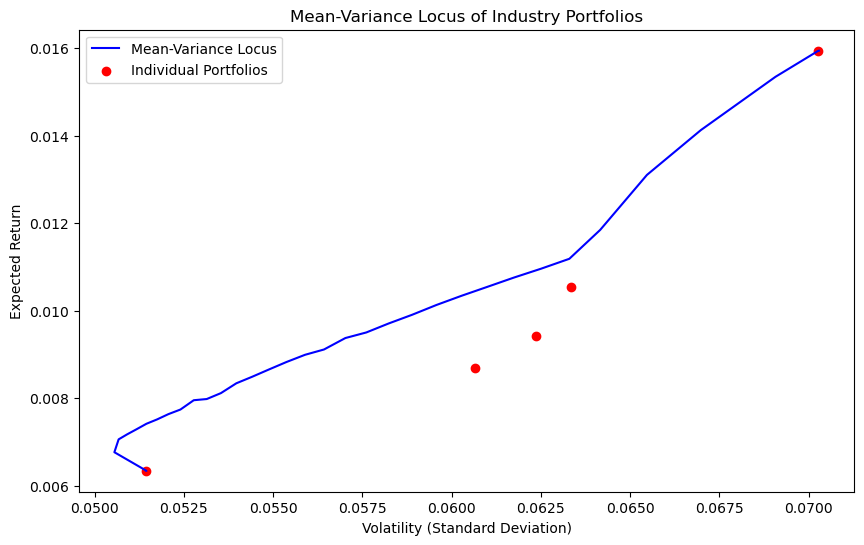

In [17]:
# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
#plt.grid(True)

(0.0, 0.07380657443890454)

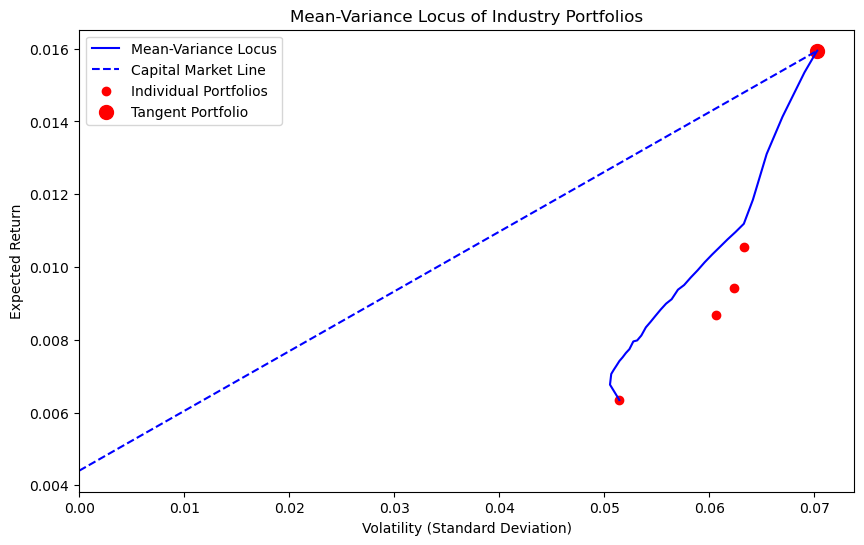

In [18]:
# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.plot(CML_volatilities, CML_returns, 'b--', label='Capital Market Line')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.scatter(volatilites_optimales[99], tangent_portfolio_return, color='red', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
#plt.grid(True)
plt.xlim(0)

In [19]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Assuming necessary data and functions are defined before this part

# Number of bootstrap samples
num_bootstrap_samples = 100

# Initialize lists to store results
all_rendements_optimaux = []
all_volatilites_optimales = []

# Bootstrap sampling and portfolio optimization for each sample
for _ in range(num_bootstrap_samples):
    # Step 1: Perform bootstrap sampling
    bootstrap_sample = df_5.sample(n=60, replace=True)  # Bootstrap sample of 60 rows with replacement

    # Step 2: Use the sampled dataframe in your existing code
    ret_5 = bootstrap_sample.values / 100
    var_5 = np.var(ret_5, axis=0, keepdims=True)
    std_5 = np.sqrt(np.var(ret_5, axis=0, keepdims=True))

    # Calculate the mean and covariance matrix
    z_barre = np.mean(ret_5, axis=0)
    Sigma_5 = np.cov(ret_5.T)

    # Initialize lists for this sample
    rendements_optimaux = []
    volatilites_optimales = []

    # Generate a series of target returns
    rendements_cibles = np.linspace(min(z_barre) - 0.015, max(z_barre) + 0.015, 100)

    # Iterate over the target returns for portfolio optimization
    for R_cible in rendements_cibles:
        W = np.ones(len(z_barre)) * (1.0 / len(z_barre))  # Reset initial weights for each iteration
        poids_optimaux = optimize(minportfolio_variance, W, Sigma_5, R_cible)
        var_optimale = minportfolio_variance(poids_optimaux, Sigma_5)
        rendement_optimal = np.dot(poids_optimaux, z_barre)

        volatilites_optimales.append(np.sqrt(var_optimale))
        rendements_optimaux.append(rendement_optimal)

    all_rendements_optimaux.append(rendements_optimaux)
    all_volatilites_optimales.append(volatilites_optimales)

# Plot each efficient frontier
plt.figure(figsize=(10, 6))
for i in range(num_bootstrap_samples):
    plt.plot(all_volatilites_optimales[i], all_rendements_optimaux[i], label=f'Bootstrap Sample {i+1}')

# Plot CML (assuming rf is defined)
CML_returns = np.linspace(rf, max(np.concatenate(all_rendements_optimaux)), 100)
CML_volatilities = (CML_returns - rf) / ((max(np.concatenate(all_rendements_optimaux)) - rf) / max(np.concatenate(all_volatilites_optimales)))
plt.plot(CML_volatilities, CML_returns, color='black', linestyle='--', label='Capital Market Line')

# Find and plot the tangent portfolio
sharpe_ratios = [(r - rf) / v for r, v in zip(np.concatenate(all_rendements_optimaux), np.concatenate(all_volatilites_optimales))]
max_sharpe_index = np.argmax(sharpe_ratios)
plt.scatter(all_volatilites_optimales[max_sharpe_index], all_rendements_optimaux[max_sharpe_index], color='red', marker='o', label='Tangent Portfolio')

plt.title('Efficient Frontier and Capital Market Line')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 